# FD004 Branch 3: LSTM-50 스케일러 비교 실험

## 📋 실험 개요

- **Dataset**: FD004
- **Model**: LSTM-50 (window_size=50)
- **Preprocessing**: RUL Clipping (RUL ≤ 125)
- **실험 목적**: 최적 스케일러 선택 및 데이터 복잡도 영향 확인

---

## 🎯 3가지 스케일러 비교

1. **StandardScaler**: 평균 0, 표준편차 1
2. **MinMaxScaler**: [0, 1] 범위로 정규화
3. **RobustScaler**: 중앙값/IQR 기반 (이상치에 강건)

---

## 📊 전처리 조건

RUL Clipping만 적용하여 스케일러 효과를 순수하게 측정

## 1. 환경 설정 및 라이브러리 Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 시드 고정
np.random.seed(42)
tf.random.set_seed(42)

## 2. 데이터 로드

In [2]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 경로 설정
DATA_PATH = '/content/drive/MyDrive/ML project'

# FD004 데이터 로드
train_fd004 = pd.read_csv(f'{DATA_PATH}/FD004_train_df.csv')
test_fd004 = pd.read_csv(f'{DATA_PATH}/FD004_test_df.csv')

## 3. 전처리: RUL Clipping 적용

RUL Clipping (RUL ≤ 125)만 적용하여 스케일러 효과를 순수하게 비교합니다.

In [4]:
# Noise 센서 정의
NOISE_SENSORS = ['s_1', 's_5', 's_8', 's_14', 's_15', 's_16', 's_18', 's_19']

# 전체 센서 (21개)
ALL_SENSORS = [f's_{i}' for i in range(1, 22)]

# 신호 센서 (Noise 제거 후 13개)
SIGNAL_SENSORS = [s for s in ALL_SENSORS if s not in NOISE_SENSORS]

In [5]:
# Branch 2 최적 전처리 적용: RUL Clipping만 적용

# RUL Clipping
train_preprocessed = train_fd004.copy()
train_preprocessed['RUL'] = train_preprocessed['RUL'].clip(upper=125)

test_preprocessed = test_fd004.copy()
test_preprocessed['RUL'] = test_preprocessed['RUL'].clip(upper=125)

# 사용할 센서 컬럼 (전체 센서 사용)
SENSOR_COLS = ALL_SENSORS

## 4. 유틸리티 함수 정의

In [6]:
def apply_scaler(train_df, test_df, sensor_cols, scaler_type='standard'):
    train_scaled = train_df.copy()
    test_scaled = test_df.copy()

    if scaler_type == 'none':
        return train_scaled, test_scaled

    # 스케일러 선택
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError(f"Unknown scaler type: {scaler_type}")

    # 스케일링 적용
    train_scaled[sensor_cols] = scaler.fit_transform(train_df[sensor_cols])
    test_scaled[sensor_cols] = scaler.transform(test_df[sensor_cols])

    return train_scaled, test_scaled

def create_sequences(df, sensor_cols, window_size=50):
    X, y = [], []

    for unit_id in df['unit'].unique():
        unit_data = df[df['unit'] == unit_id].sort_values('cycle')

        sensor_values = unit_data[sensor_cols].values
        rul_values = unit_data['RUL'].values

        for i in range(len(sensor_values) - window_size + 1):
            X.append(sensor_values[i:i+window_size])
            y.append(rul_values[i+window_size-1])

    return np.array(X), np.array(y)

## 5. LSTM-50 모델 정의

In [7]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(100, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(25),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

## 6. 스케일러별 실험 함수

In [8]:
def run_scaler_experiment(train_data, test_data, sensor_cols, scaler_type, window_size=50):
    scaler_names = {
        'standard': 'StandardScaler',
        'minmax': 'MinMaxScaler',
        'robust': 'RobustScaler',
        'none': 'None (No Scaling)'
    }

    # 스케일링 적용
    train_scaled, test_scaled = apply_scaler(train_data, test_data, sensor_cols, scaler_type)

    # 시퀀스 데이터 생성
    X_train, y_train = create_sequences(train_scaled, sensor_cols, window_size)
    X_test, y_test = create_sequences(test_scaled, sensor_cols, window_size)

    # Train/Validation 분할
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, shuffle=False
    )

    # 모델 생성
    model = build_lstm_model(input_shape=(window_size, len(sensor_cols)))

    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    # 모델 학습
    history = model.fit(
        X_train_split, y_train_split,
        validation_data=(X_val_split, y_val_split),
        epochs=100,
        batch_size=128,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    epochs_trained = len(history.history['loss'])
    stopped_early = epochs_trained < 100

    # 예측
    y_train_pred = model.predict(X_train, verbose=0).flatten()
    y_test_pred = model.predict(X_test, verbose=0).flatten()

    # 평가
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    return {
        'scaler': scaler_type,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
    }

## 7. 3가지 스케일러 실험 실행

### 7.1 StandardScaler

In [9]:
result_standard = run_scaler_experiment(
    train_data=train_preprocessed,
    test_data=test_preprocessed,
    sensor_cols=SENSOR_COLS,
    scaler_type='standard'
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 19.


### 7.2 MinMaxScaler

In [10]:
result_minmax = run_scaler_experiment(
    train_data=train_preprocessed,
    test_data=test_preprocessed,
    sensor_cols=SENSOR_COLS,
    scaler_type='minmax'
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 19.


### 7.3 RobustScaler

In [11]:
result_robust = run_scaler_experiment(
    train_data=train_preprocessed,
    test_data=test_preprocessed,
    sensor_cols=SENSOR_COLS,
    scaler_type='robust'
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 40: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 50: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 50: early stopping
Restoring model weights from the end of the best epoch: 35.


## 8. 결과 비교 및 시각화

In [12]:
# 결과 정리
results = [result_standard, result_minmax, result_robust]
df_results = pd.DataFrame(results)

# StandardScaler 대비 개선율 계산
baseline_rmse = df_results[df_results['scaler'] == 'standard']['test_rmse'].values[0]
df_results['improvement_%'] = ((baseline_rmse - df_results['test_rmse']) / baseline_rmse * 100).round(2)

df_results

,scaler,train_rmse,test_rmse,test_mae,test_r2,improvement_%
0,standard,41.919998,37.256390,34.991447,-0.679276,0.00
1,minmax,41.917725,37.185706,34.922279,-0.672910,0.19
2,robust,15.454384,19.483292,15.801526,0.540754,47.70


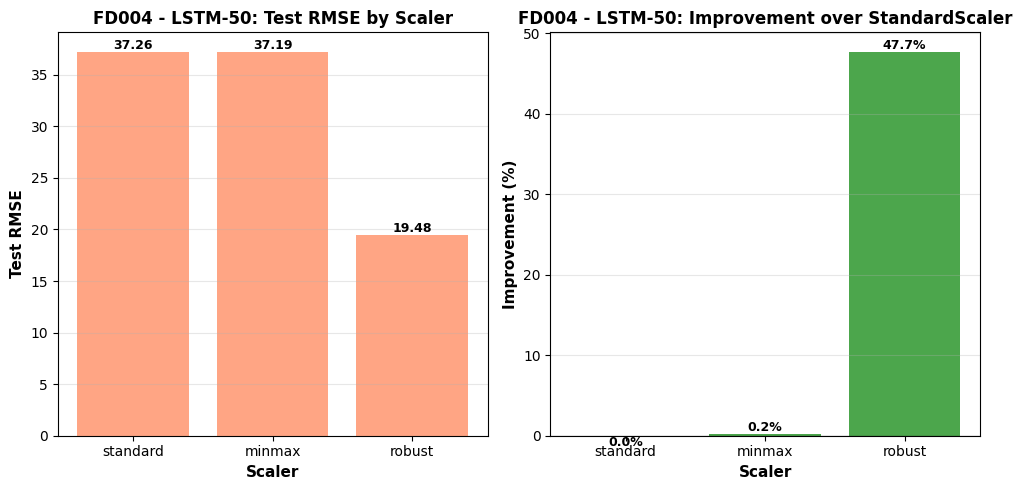

In [14]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 1. Test RMSE 비교
ax1 = axes[0]
bars1 = ax1.bar(df_results['scaler'], df_results['test_rmse'], color='coral', alpha=0.7)
ax1.set_xlabel('Scaler', fontsize=11, fontweight='bold')
ax1.set_ylabel('Test RMSE', fontsize=11, fontweight='bold')
ax1.set_title('FD004 - LSTM-50: Test RMSE by Scaler', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x')

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. 개선율 비교
ax2 = axes[1]
colors = ['gray' if x == 0 else 'green' if x > 0 else 'red' for x in df_results['improvement_%']]
bars2 = ax2.bar(df_results['scaler'], df_results['improvement_%'], color=colors, alpha=0.7)
ax2.set_xlabel('Scaler', fontsize=11, fontweight='bold')
ax2.set_ylabel('Improvement (%)', fontsize=11, fontweight='bold')
ax2.set_title('FD004 - LSTM-50: Improvement over StandardScaler', fontsize=12, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x')

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom' if height > 0 else 'top',
             fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()